http://localhost:8888/notebooks/Python-ColorWebucator.html

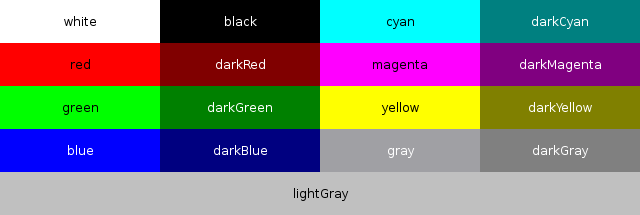

In [15]:
from PIL import Image
im = Image.open("/home/jack/Desktop/R-Studio/qt-colors.png") 
im

In [5]:
!ls -rant *.py

-rw-rw-r-- 1 1000 1000  3726 Oct 26 08:26 outlineblack.py
-rwxrwxr-x 1 1000 1000   546 Oct 27 18:40 ani.py
-rw-rw-r-- 1 1000 1000 14128 Oct 27 18:48 examples.py
-rw-rw-r-- 1 1000 1000   915 Oct 27 19:23 Painter.py
-rw-rw-r-- 1 1000 1000 14319 Oct 28 10:06 viddrawImage.py
-rw-rw-r-- 1 1000 1000 14585 Oct 28 12:04 mAke.py
-rw-rw-r-- 1 1000 1000 14365 Oct 28 21:32 drawImage.py
-rw-rw-r-- 1 1000 1000   616 Nov  2 09:44 myturtle.py
-rw-rw-r-- 1 1000 1000 19540 Nov  2 09:50 drawperlin.py


In [6]:
%%writefile drawperlin.py
#!/home/jack/miniconda3/envs/cloned_base/bin/python

"""
@author: The Absolute Tinkerer
"""

import os
import math
import numpy as np

from PyQt5.QtGui import QColor


def QColor_HSV(h, s, v, a=255):
    """
    Hue        : > -1 [wraps between 0-360]
    Saturation : 0-255
    Value      : 0-255
    Alpha      : 0-255
    """
    color = QColor()
    color.setHsv(*[int(e) for e in [h, s, v, a]])
    return color


def save(p, fname='image', folder='Images', extension='jpg', quality=100, overwrite=True):
    if not os.path.exists(folder):
        os.mkdir(folder)

    # The image name
    imageFile = f'{folder}/{fname}.{extension}'

    # Do not overwrite the image if it exists already
    if os.path.exists(imageFile):
        assert overwrite, 'File exists and overwrite is set to False!'

    # fileName, format, quality [0 through 100]
    p.saveImage(imageFile, imageFile[-3:], quality)


def Perlin2D(width, height, n_x, n_y, clampHorizontal=False, clampVertical=False):
    """
    Constructor

    Optimizations were gained from studying:
    https://github.com/pvigier/perlin-numpy/blob/master/perlin_numpy/perlin2d.py

    Parameters:
    -----------
    width : int
        The width of the canvas
    height : int
        The height of the canvas
    n_x : int
        The number of x tiles; must correspond to an integer x-edge length
    n_y : int
        The number of y tiles; must correspond to an integer y-edge length
    clampHorizontal : boolean
        Imagine the Perlin Noise on a sheet of paper - form a cylinder with
        the horizontal edges. If True, cylinder will be continuous noise
    clampVertical : boolean
        Imagine the Perlin Noise on a sheet of paper - form a cylinder with
        the vertical edges. If True, cylinder will be continuous noise

    Returns:
    --------
    <value> : numpy array
        noise values for array[width, height] between -1 and 1
    """
    # First ensure even number of n_x and n_y divide into the width and height,
    # respectively and convert float to int
    n_x = int(n_x)
    n_y = int(n_y)
    msg = 'n_x and n_y must evenly divide into width and height, respectively'
    assert width % n_x == 0 and height % n_y == 0, msg

    # We start off by defining our interpolation function
    def fade(t):
        return t * t * t * (t * (t * 6 - 15) + 10)

    # Next, we generate the gradients that we are using for each corner point
    # of the grid
    angles = 2 * np.pi * np.random.rand(n_x + 1, n_y + 1)
    r = math.sqrt(2)  # The radius of the unit circle
    gradients = np.dstack((r * np.cos(angles), r * np.sin(angles)))

    # Now, if the user has chosen to clamp at all, set the first and last row/
    # column equal to one another
    if clampHorizontal:
        gradients[-1, :] = gradients[0, :]
    if clampVertical:
        gradients[:, -1] = gradients[:, 0]

    # Now that gradient vectors are complete, we need to create the normalized
    # distance from each point to its starting grid point. In other words, this
    # is the normalized distance from the grid tile's origin based upon the
    # grid tile's width and height
    delta = (n_x / width, n_y / height)
    grid = np.mgrid[0:n_x:delta[0], 0:n_y:delta[1]].transpose(1, 2, 0) % 1

    # At this point, we need to compute the dot products for each corner of the
    # grid. To do this, we first need proper-dimensioned gradient vectors - do
    # this now. A computation for number of points per tile is needed as well
    px, py = int(width / n_x), int(height / n_y)
    gradients = gradients.repeat(px, 0).repeat(py, 1)
    g00 = gradients[:-px, :-py]
    g10 = gradients[px:, :-py]
    g01 = gradients[:-px, py:]
    g11 = gradients[px:, py:]

    # Compute dot products for each corner
    d00 = np.sum(g00 * grid, 2)
    d10 = np.sum(g10 * np.dstack((grid[:, :, 0] - 1, grid[:, :, 1])), 2)
    d01 = np.sum(g01 * np.dstack((grid[:, :, 0], grid[:, :, 1] - 1)), 2)
    d11 = np.sum(g11 * np.dstack((grid[:, :, 0] - 1, grid[:, :, 1] - 1)), 2)

    # We're doing improved perlin noise, so we use a fade function to compute
    # the x and y fractions used in the linear interpolation computation
    # t is the faded grid
    # u is the faded dot product between the top corners
    # v is the faded dot product between the bottom corners
    # _x and _y are the fractional (0-1) location of x, y in the tile
    t = fade(grid)
    u = d00 + t[:, :, 0] * (d10 - d00)
    v = d01 + t[:, :, 0] * (d11 - d01)

    # Now perform the second dimension's linear interpolation to return value
    return u + t[:, :, 1] * (v - u)


"""
@author: The Absolute Tinkerer
"""

import os
import math
import time
import random

import numpy as np

from PIL import Image

from PyQt5.QtGui import QColor, QPen, QPixmap
from PyQt5.QtCore import QPointF, QRect

import Painter
#from utils import QColor_HSV, save, Perlin2D


def draw_white_noise(width, height, fname):
    assert not os.path.exists(fname), 'File already exists!'

    # Create a matrix of random values between zero and one
    pixels = np.random.random(size=(height, width))

    # Now modify the random values to be 0-255 (pixel color range)
    pixels = 255*pixels

    # The function to write the array of pixels to an image requires integers, not float values
    pixels = pixels.astype(np.uint8)

    # We choose to make random values grayscale, so each RGB element is identical. This code adds the third dimension
    # to our pixels array
    pixels = pixels[:, :, np.newaxis]

    # We need to repeat each value to finalize the pixels arrays in the grayscale space
    pixels = np.repeat(pixels, 3, axis=2)

    # Now create the image from an array of pixels
    im = Image.fromarray(pixels)

    # Save the image to file
    im.save(fname)


def draw_perlin(nx, ny, width, height, fname):
    assert not os.path.exists(fname), 'File already exists'
    nx = int(nx)
    ny = int(ny)
    # Initialize Perlin Noise
    noise = (Perlin2D(width, height, nx, ny) + 1)/2

    # Convert to pixels
    pixels = 255 * noise
    pixels = pixels.astype(np.uint8)
    pixels = pixels[:, :, np.newaxis]
    pixels = np.repeat(pixels, 3, axis=2)

    # Create and save the image from pixels
    im = Image.fromarray(pixels)
    im.save(fname)

    return noise


def draw_vectors(nx, ny, width, height, seed=random.randint(0, 100000000), flow_length=100, n_vectors=50):
    p_path = f'{seed}_1_perlin_noise.jpg'
    v_path = f'{seed}_2_vectors'
    f_path = f'{seed}_3_flow_field'
    nx = int(nx)
    ny = int(ny)
    # Ensure we don't overwrite paths
    assert not os.path.exists(p_path), 'Perlin Noise image already exists!'
    assert not os.path.exists(v_path), 'Vectors image already exists!'
    assert not os.path.exists(f_path), 'Flow field image already exists!'

    # Set the random seed for repeatability
    np.random.seed(seed)

    # Create the Perlin Noise image
    noise = draw_perlin(nx, ny, width, height, p_path)

    # Initialize the painter object for drawing
    p = Painter.Painter(width, height)
    p.setRenderHint(p.Antialiasing)  # allow smooth drawing

    def draw_arrow(p, x_i, y_i, length=100, angle=0):
        # Compute the second points and draw the arrow body
        x_f = x_i + length*math.cos(math.radians(angle))
        y_f = y_i - length*math.sin(math.radians(angle))
        p.drawLine(x_i, y_i, x_f, y_f)

        # Compute the arrow head second points
        a_angle1, a_angle2 = math.radians(angle-30), math.radians(angle+30)
        x1 = x_f - (length/10)*math.cos(a_angle1)
        y1 = y_f + (length/10)*math.sin(a_angle1)
        x2 = x_f - (length/10)*math.cos(a_angle2)
        y2 = y_f + (length/10)*math.sin(a_angle2)
        p.drawLine(x_f, y_f, x1, y1)
        p.drawLine(x_f, y_f, x2, y2)

    # Load the Perlin Noise image and draw it with the painter
    p.drawPixmap(QRect(0, 0, width, height), QPixmap(p_path))

    # Now we're drawing red arrows for vectors, so set the pen color to red
    p.setPen(QColor(255, 0, 0))

    # We need arrow locations, so create a grid of n_vectors x n_vectors, excluding the image border
    _nx, _ny = n_vectors, n_vectors
    dx, dy = width / (_nx + 1), height / (_ny + 1)
    x_points = [dx + i*dx for i in range(_nx)]
    y_points = [dy + i*dy for i in range(_ny)]

    # Draw the arrows
    for x in x_points:
        for y in y_points:
            angle = 360*noise[int(x), int(y)]
            draw_arrow(p, x, y, length=min(dx, dy), angle=angle)

    # Save the vector image
    save(p, fname=v_path, folder='XXXX/New/')

    # Now draw the flow field. Start by initializing a new painter
    p = Painter.Painter(width, height)
    p.setRenderHint(p.Antialiasing)  # allow smooth drawing
    p.setPen(QColor(0, 0, 0))  # pen color set to black
    p.setPen(QColor(0, 0, 200))  # pen color set to blue
    # Step size between points
    STEP_SIZE = 0.001 * max(width, height)

    # Draw the flow field
    for x in x_points:
        for y in y_points:
            # The starting position
            x_s, y_s = x, y
            # The current line length tracking variable
            c_len = 0
            while c_len < flow_length:
                # angle between 0 and 2*pi
                angle = 2 * noise[int(x_s), int(y_s)] * math.pi

                # Compute the new point
                x_f = x_s + STEP_SIZE * math.cos(angle)
                y_f = y_s - STEP_SIZE * math.sin(angle)

                # Draw the line
                p.drawLine(QPointF(x_s, y_s), QPointF(x_f, y_f))

                # Update the line length
                c_len += math.sqrt((x_f - x_s) ** 2 + (y_f - y_s) ** 2)

                # Break from the loop if the new point is outside our image bounds
                # or if we've exceeded the line length; otherwise update the point
                if x_f < 0 or x_f >= width or y_f < 0 or y_f >= height or c_len > flow_length:
                    break
                else:
                    x_s, y_s = x_f, y_f
    save(p, fname=f_path, folder='XXXX/New')


def draw_flow_field(width, height, seed=random.randint(0, 100000000)):
    # Set the random seed for repeatability
    np.random.seed(seed)

    # These are color hues
    colors = [200, 140, 70, 340, 280]
    for i, mod in enumerate(colors):
        print('Starting Image %s/%s' % (i + 1, len(colors)))
        p = Painter.Painter(width, height)

        # Allow smooth drawing
        p.setRenderHint(p.Antialiasing)

        # Draw the background color
        p.fillRect(0, 0, width, height, QColor(0, 0, 0))

        # Set the pen color
        p.setPen(QPen(QColor(150, 150, 225, 5), 2))

        num = 1
        for j in range(num):
            print('Creating Noise... (%s/%s)' % (j + 1, num))
            p_noise = Perlin2D(width, height, 2, 2)
            print('Noise Generated! (%s/%s)' % (j + 1, num))

            MAX_LENGTH = 2 * width
            STEP_SIZE = 0.001 * max(width, height)
            NUM = int(width * height / 1000)
            POINTS = [(random.randint(0, width - 1), random.randint(0, height - 1)) for i in range(NUM)]

            for k, (x_s, y_s) in enumerate(POINTS):
                print(f'{100 * (k + 1) / len(POINTS):.1f}'.rjust(5) + '% Complete', end='\r')

                # The current line length tracking variable
                c_len = 0

                # Actually draw the flow field
                while c_len < MAX_LENGTH:
                    # Set the pen color for this segment
                    sat = 200 * (MAX_LENGTH - c_len) / MAX_LENGTH
                    hue = (mod + 130 * (height - y_s) / height) % 360
                    p.setPen(QPen(QColor_HSV(hue, sat, 255, 20), 2))

                    # angle between -pi and pi
                    angle = p_noise[int(x_s), int(y_s)] * math.pi

                    # Compute the new point
                    x_f = x_s + STEP_SIZE * math.cos(angle)
                    y_f = y_s + STEP_SIZE * math.sin(angle)

                    # Draw the line
                    p.drawLine(QPointF(x_s, y_s), QPointF(x_f, y_f))

                    # Update the line length
                    c_len += math.sqrt((x_f - x_s) ** 2 + (y_f - y_s) ** 2)

                    # Break from the loop if the new point is outside our image bounds
                    # or if we've exceeded the line length; otherwise update the point
                    if x_f < 0 or x_f >= width or y_f < 0 or y_f >= height or c_len > MAX_LENGTH:
                        break
                    else:
                        x_s, y_s = x_f, y_f

                    save(p, fname=f'image_{i}_{mod}_{num}_{seed}', folder='newseries/', overwrite=True)


def draw_perlin_rounding(width, height, fname, seed=random.randint(0, 100000000)):
    # Ensure we don't overwrite paths
    assert not os.path.exists(fname), 'Image already exists!'

    # Set the random seed for repeatability
    np.random.seed(seed)

    # Initialize a new painter
    p = Painter.Painter(width, height)
    p.setRenderHint(p.Antialiasing)

    # Draw the background color
    #p.fillRect(0, 0, width, height, QColor(0, 0, 0))
    p.fillRect(0, 0, width, height, QColor("darkRed"))

    # Set the pen color
    p.setPen(QColor(200, 200, 200))
    p.setPen(QColor("yellow"))

    print('Creating Noise...', end='', flush=True)
    noise = Perlin2D(width, height, 1, 1)
    print('Done!')

    # The maximum line length and step size
    MAX_LENGTH = 1000
    STEP_SIZE = 0.001 * max(width, height)

    # Compute a grid 200x200 points, centered in the screen
    dx, dy = width / (200 + 1), height / (200 + 1)
    POINTS = [[(i+1)*dx, (j+1)*dy] for i in range(200) for j in range(200)]

    for i, (x_s, y_s) in enumerate(POINTS):
        print(f'{100 * (i + 1) / len(POINTS):.1f}'.rjust(5) + '% Complete', end='\r')

        # The current line length tracking variable
        c_len = 0
        while c_len < MAX_LENGTH:
            # angle between -pi and pi
            angle = math.pi*noise[int(x_s), int(y_s)]

            # Round the angle to pi/4 increments
            angle = round(angle / (math.pi / 4)) * (math.pi / 4)

            # Compute the new point
            x_f = x_s + STEP_SIZE * math.cos(angle)
            y_f = y_s + STEP_SIZE * math.sin(angle)

            # Draw the line
            p.drawLine(x_s, y_s, x_f, y_f)

            # Update the line length
            c_len += math.sqrt((x_f - x_s) ** 2 + (y_f - y_s) ** 2)

            # Break from the loop if the new point is outside our image bounds
            # or if we've exceeded the line length; otherwise update the point
            if (x_f < 0 or x_f >= width or y_f < 0 or y_f >= height or
                    c_len > MAX_LENGTH):
                break
            else:
                x_s, y_s = x_f, y_f
    print('100% Complete!')
    save(p, fname=f'{fname}_{seed}', folder='.')

class Body:
    def __init__(self, x, y, vx, vy):
        self._position = np.array([x, y], dtype=np.float64)
        self._velocity = np.array([vx, vy], dtype=np.float64)

    @property
    def position(self):
        return self._position

    @property
    def velocity(self):
        return self._velocity

    def update(self, dt):
        # update the body position
        self._position = self._position + dt*self._velocity


class ExpandingCircleRandom:
    def __init__(self, radius, num_bodies, center=(0, 0), v_limits=(-2, 2)):
        self._bodies = [Body(center[0] + radius*math.cos(i*2*math.pi/num_bodies),
                             center[1] + radius*math.sin(i*2*math.pi/num_bodies),
                             v_limits[0]+(v_limits[1]-v_limits[0])*random.random(),
                             v_limits[0]+(v_limits[1]-v_limits[0])*random.random()) for i in range(num_bodies)]

    def draw(self, dt, Painter):
        # Connect the dots between each body
        for i in range(len(self._bodies)):
            # Handle the wrapping case
            if i == len(self._bodies) - 1:
                p1 = QPointF(*self._bodies[i].position)
                p2 = QPointF(*self._bodies[0].position)
            else:
                p1 = QPointF(*self._bodies[i].position)
                p2 = QPointF(*self._bodies[i+1].position)
            Painter.drawLine(p1, p2)

        # Update the position of each body
        for i in range(len(self._bodies)):
            self._bodies[i].update(dt)


class ExpandingCircleNoise:
    def __init__(self, radius, num_bodies, noise, center=(0, 0), v_max=2):
        self._bodies = [Body(center[0] + radius*math.cos(i*2*math.pi/num_bodies),
                             center[1] + radius*math.sin(i*2*math.pi/num_bodies),
                             0, 0) for i in range(num_bodies)]
        self._v_max = v_max
        self._noise = noise

    def draw(self, dt, painter):
        # Connect the dots between each body
        for i in range(len(self._bodies)):
            # Handle the wrapping case
            if i == len(self._bodies) - 1:
                p1 = QPointF(*self._bodies[i].position)
                p2 = QPointF(*self._bodies[0].position)
            else:
                p1 = QPointF(*self._bodies[i].position)
                p2 = QPointF(*self._bodies[i + 1].position)
            painter.drawLine(p1, p2)

            # Try to update the velocity for each body. If we can't its because the point is beyond the noise
            # field we've created, so at that point, just maintain velocity.
            try:
                a = math.pi*self._noise[int(p1.x()), int(p1.y())]
                v = np.array([self._v_max*math.cos(a), self._v_max*math.sin(a)])
                self._bodies[i]._velocity = v
            except IndexError:
                pass

        # Update the position of each body
        for i in range(len(self._bodies)):
            self._bodies[i].update(dt)

def draw_delta_body(width, height, iterations = 2000,seed=random.randint(0, 100000000), mode='noise'):
    #def draw_delta_body(width, height, seed=random.randint(0, 100000000), mode='noise'):
    assert mode in ['noise', 'random'], 'Mode must either be "noise" or "random"'

    # Set the random seed for repeatability
    np.random.seed(seed)
    random.seed(seed)

    # Initialize the painter
    p = Painter.Painter(width, height)
    p.setRenderHint(p.Antialiasing)  # Allow smooth drawing

    # Draw the background color
    #p.fillRect(0, 0, width, height, QColor("0, 0, 0"))
    p.fillRect(0, 0, width, height, QColor("darkBlue"))

    # Set the pen color
    #p.setPen(QPen(QColor(220, 220, 220, 5), 1))
    p.setPen(QPen(QColor(255, 215, 0, 10), 3))
    #RGB(255,215,0)
    # Initialize the expanding circle centered in the canvas
    if mode == 'random':
        circle = ExpandingCircleRandom(width/8, 100, center=(width/2, height/2), v_limits=(-2, 2))
    elif mode == 'noise':
        noise = Perlin2D(width, height, 5, 5)
        circle = ExpandingCircleNoise(width/6, 200, noise, center=(width/4, height/2), v_max=5)
    else:
        circle = None

    # Initialize the delta time we're applying to each update
    dt = 0.3

    #iterations = 2000
    for i in range(iterations):
        circle.draw(dt, p)

        #save(p, fname=f'delta_{i}_{mode}_{seed}', folder='XXXX/', overwrite=True)
    save(p, fname=f'delta-{i}_{mode}_{seed}', folder='XXXX/', overwrite=True)

#cnt=1
#width= 1000
#height=1000
#fname = "XXXX/o"
#print(fname)
#draw_perlin_rounding(width, height, fname, seed=random.randint(0, 100000000))
#draw_delta_body(width, height, iterations = 1000,seed=random.randint(0, 100000000), mode='noise')

Overwriting drawperlin.py


In [3]:
width = 1000
height = 1000
p = Painter.Painter(width, height)
# Allow smooth drawing
p.setRenderHint(p.Antialiasing)
# Draw the background color
p.fillRect(0, 0, width, height, QColor(255,211,155))
# Set the pen color
p.setPen(QPen(QColor(0, 120, 180, 10), 3))
x_i = 500
y_i = 500
length=100
angle=0
x_f = x_i + length*math.cos(math.radians(angle))
y_f = y_i - length*math.sin(math.radians(angle))
x_f = int(x_f)
y_f = int(y_f)
for inc in range(0,500):
    incs = 0
    if inc %5 == 0:incs=incs-3
    p.drawLine(x_i+inc, y_i+inc, x_f-incs, y_f-incs)

v_path = "YYooY"
 # Save the vector image
save(p, fname=v_path, folder='XXXX/New/')
#p.setPen(QColor(120,120,0))

In [93]:
width= 1000
height=1000
for inc in range(2,1000,2):
    fname = "/home/jack/Desktop/R-Studio/newseries/test_"+str(inc)+".jpg"
    nx = inc
    ny = inc
    try:
        #draw_perlin(nx, ny, width, height, fname)
        draw_vectors(nx, ny, width, height, seed=random.randint(0, 100000000), flow_length=150, n_vectors=50)
    except:
        pass

/tmp/ipykernel_4579/1656121105.py:218: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  p.drawLine(x_i, y_i, x_f, y_f)
/tmp/ipykernel_4579/1656121105.py:226: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  p.drawLine(x_f, y_f, x1, y1)
/tmp/ipykernel_4579/1656121105.py:227: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  p.drawLine(x_f, y_f, x2, y2)


In [48]:
!ls -rant newseries

total 13432
-rw-rw-r--  1 1000 1000  813077 Oct 30 08:54 image_0_200_1_18430966.jpg
-rw-rw-r--  1 1000 1000 1816729 Oct 30 09:23 8430966.jpg
-rw-rw-r--  1 1000 1000  621132 Oct 30 12:30 image_.jpg
-rw-rw-r--  1 1000 1000  621132 Oct 30 12:30 image_1_140_1_18430966.jpg
-rw-rw-r--  1 1000 1000   28617 Oct 30 12:44 00011spc.jpg
-rw-rw-r--  1 1000 1000   28617 Oct 30 12:44 00021spc.jpg
-rw-rw-r--  1 1000 1000   34983 Oct 30 12:44 00012spc.jpg
-rw-rw-r--  1 1000 1000   34983 Oct 30 12:44 00001spc.jpg
-rw-rw-r--  1 1000 1000   39957 Oct 30 12:44 00013spc.jpg
-rw-rw-r--  1 1000 1000   39957 Oct 30 12:44 00002spc.jpg
-rw-rw-r--  1 1000 1000   44075 Oct 30 12:44 00014spc.jpg
-rw-rw-r--  1 1000 1000   44075 Oct 30 12:44 00003spc.jpg
-rw-rw-r--  1 1000 1000   69415 Oct 30 12:44 00015spc.jpg
-rw-rw-r--  1 1000 1000   69415 Oct 30 12:44 00004spc.jpg
-rw-rw-r--  1 1000 1000   95862 Oct 30 12:44 00016spc.jpg
-rw-rw-r--  1 1000 1000   95862 Oct 30 12:44 00005spc.jpg
-rw-rw-r--  1 1000 1000  108912 Oct

In [50]:
!ffmpeg -i newseries/slowout360.mp4 -i newseries/crack360spc.png -filter_complex "[0:v][1:v] overlay=0:0" \
-c:a copy newseries/output.mp4


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/jack/miniconda3/envs/cloned_base --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpro

In [62]:
!ffmpeg -i newseries/output.60fps.mp4 -vf scale=360x360 -vcodec libx264 -crf 24 newseries/smoutoutput.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/jack/miniconda3/envs/cloned_base --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpro

In [ ]:
!ffmpeg -i /home/jack/Documents/QmdjwggR6x7ex3p99GWZWQqut7RsPfu4QofvYcA8CPvWyQ.mp4 \
-vcodec libx264 -crf 24 -vf "minterpolate=fps=60:mi_mode=mci:mc_mode=aobmc:me_mode=bidir:vsbmc=1" \
  -y newseries/outputS.60fps.mp4

In [ ]:
/home/jack/Documents/QmNfgkiiAazV14NkS5PGJHNMigDs4VQYEB3wz2DcyB6FDa.mp4

In [81]:
!ffmpeg -i /home/jack/Documents/QmbFosnt9NSPkPCDRZh22TC5FYcrHY4M6DFJu6hhmcjVL3.mp4 \
-crf 20 -filter_complex  "scale=360:260,minterpolate=fps=60:mi_mode=mci:mc_mode=aobmc:me_mode=bidir:vsbmc=1" \
  -y newseries/girl20.60fps.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/jack/miniconda3/envs/cloned_base --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpro

In [75]:
!ffmpeg -i /home/jack/Documents/QmNfgkiiAazV14NkS5PGJHNMigDs4VQYEB3wz2DcyB6FDa.mp4 \
-crf 30 -vf "minterpolate=fps=60:mi_mode=mci:mc_mode=aobmc:me_mode=bidir:vsbmc=1" \
  -y newseries/newput30.60fps.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/jack/miniconda3/envs/cloned_base --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpro

In [67]:
!ffmpeg -i newseries/vid360.mp4 -i newseries/crack360spc.png -filter_complex \
"[1:v]format=argb,geq=r='r(X,Y)':a='1.0*alpha(X,Y)'[zork]; \
   [0:v][zork]overlay" -vcodec libx264 -y newseries/outputvideo.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/jack/miniconda3/envs/cloned_base --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostpro

In [43]:
width= 1000
height=1000
for inc in range(2,1000,2):
    fname = "/home/jack/Desktop/R-Studio/newseries/test_"+str(inc)+".jpg"
    nx = inc
    ny = inc
    try:
        draw_perlin(nx, ny, width, height, fname)
    except:
        pass

In [34]:
width= 1000
height=1000
draw_flow_field(width, height, seed=random.randint(0, 100000000))

Starting Image 1/5
Creating Noise... (1/1)
Noise Generated! (1/1)
Starting Image 2/5
Creating Noise... (1/1)
Noise Generated! (1/1)


KeyboardInterrupt: 

In [33]:
width= 1000
height=1000
draw_delta_body(width, height, iterations = 2000,seed=random.randint(0, 100000000), mode='noise')

In [ ]:
cnt=1
width= 1000
height=1000
fname = "XXXX/o"
print(fname)
draw_perlin_rounding(width, height, fname, seed=random.randint(0, 100000000))
#draw_delta_body(width, height, iterations = 1000,seed=random.randint(0, 100000000), mode='noise')

In [19]:
!ls XXXX

delta-1999_noise_69926699.jpg  keep


In [ ]:
"""
@author: The Absolute Tinkerer
"""

import os
import math
import time
import random

import numpy as np

from PIL import Image

from PyQt5.QtGui import QColor, QPen, QPixmap
from PyQt5.QtCore import QPointF, QRect

import painter
from utils import QColor_HSV, save, Perlin2D


def draw_white_noise(width, height, fname):
    assert not os.path.exists(fname), 'File already exists!'

    # Create a matrix of random values between zero and one
    pixels = np.random.random(size=(height, width))

    # Now modify the random values to be 0-255 (pixel color range)
    pixels = 255*pixels

    # The function to write the array of pixels to an image requires integers, not float values
    pixels = pixels.astype(np.uint8)

    # We choose to make random values grayscale, so each RGB element is identical. This code adds the third dimension
    # to our pixels array
    pixels = pixels[:, :, np.newaxis]

    # We need to repeat each value to finalize the pixels arrays in the grayscale space
    pixels = np.repeat(pixels, 3, axis=2)

    # Now create the image from an array of pixels
    im = Image.fromarray(pixels)

    # Save the image to file
    im.save(fname)


def draw_perlin(nx, ny, width, height, fname):
    assert not os.path.exists(fname), 'File already exists'

    # Initialize Perlin Noise
    noise = (Perlin2D(width, height, nx, ny) + 1)/2

    # Convert to pixels
    pixels = 255 * noise
    pixels = pixels.astype(np.uint8)
    pixels = pixels[:, :, np.newaxis]
    pixels = np.repeat(pixels, 3, axis=2)

    # Create and save the image from pixels
    im = Image.fromarray(pixels)
    im.save(fname)

    return noise


def draw_vectors(nx, ny, width, height, seed=random.randint(0, 100000000), flow_length=100, n_vectors=50):
    p_path = f'{seed}_1_perlin_noise.jpg'
    v_path = f'{seed}_2_vectors'
    f_path = f'{seed}_3_flow_field'

    # Ensure we don't overwrite paths
    assert not os.path.exists(p_path), 'Perlin Noise image already exists!'
    assert not os.path.exists(v_path), 'Vectors image already exists!'
    assert not os.path.exists(f_path), 'Flow field image already exists!'

    # Set the random seed for repeatability
    np.random.seed(seed)

    # Create the Perlin Noise image
    noise = draw_perlin(nx, ny, width, height, p_path)

    # Initialize the painter object for drawing
    p = painter.Painter(width, height)
    p.setRenderHint(p.Antialiasing)  # allow smooth drawing

    def draw_arrow(p, x_i, y_i, length=100, angle=0):
        # Compute the second points and draw the arrow body
        x_f = x_i + length*math.cos(math.radians(angle))
        y_f = y_i - length*math.sin(math.radians(angle))
        p.drawLine(x_i, y_i, x_f, y_f)

        # Compute the arrow head second points
        a_angle1, a_angle2 = math.radians(angle-30), math.radians(angle+30)
        x1 = x_f - (length/10)*math.cos(a_angle1)
        y1 = y_f + (length/10)*math.sin(a_angle1)
        x2 = x_f - (length/10)*math.cos(a_angle2)
        y2 = y_f + (length/10)*math.sin(a_angle2)
        p.drawLine(x_f, y_f, x1, y1)
        p.drawLine(x_f, y_f, x2, y2)

    # Load the Perlin Noise image and draw it with the painter
    p.drawPixmap(QRect(0, 0, width, height), QPixmap(p_path))

    # Now we're drawing red arrows for vectors, so set the pen color to red
    p.setPen(QColor(255, 0, 0))

    # We need arrow locations, so create a grid of n_vectors x n_vectors, excluding the image border
    _nx, _ny = n_vectors, n_vectors
    dx, dy = width / (_nx + 1), height / (_ny + 1)
    x_points = [dx + i*dx for i in range(_nx)]
    y_points = [dy + i*dy for i in range(_ny)]

    # Draw the arrows
    for x in x_points:
        for y in y_points:
            angle = 360*noise[int(x), int(y)]
            draw_arrow(p, x, y, length=min(dx, dy), angle=angle)

    # Save the vector image
    save(p, fname=v_path, folder='.')

    # Now draw the flow field. Start by initializing a new painter
    p = painter.Painter(width, height)
    p.setRenderHint(p.Antialiasing)  # allow smooth drawing
    p.setPen(QColor(0, 0, 0))  # pen color set to black

    # Step size between points
    STEP_SIZE = 0.001 * max(width, height)

    # Draw the flow field
    for x in x_points:
        for y in y_points:
            # The starting position
            x_s, y_s = x, y
            # The current line length tracking variable
            c_len = 0
            while c_len < flow_length:
                # angle between 0 and 2*pi
                angle = 2 * noise[int(x_s), int(y_s)] * math.pi

                # Compute the new point
                x_f = x_s + STEP_SIZE * math.cos(angle)
                y_f = y_s - STEP_SIZE * math.sin(angle)

                # Draw the line
                p.drawLine(QPointF(x_s, y_s), QPointF(x_f, y_f))

                # Update the line length
                c_len += math.sqrt((x_f - x_s) ** 2 + (y_f - y_s) ** 2)

                # Break from the loop if the new point is outside our image bounds
                # or if we've exceeded the line length; otherwise update the point
                if x_f < 0 or x_f >= width or y_f < 0 or y_f >= height or c_len > flow_length:
                    break
                else:
                    x_s, y_s = x_f, y_f
    save(p, fname=f_path, folder='.')


def draw_flow_field(width, height, seed=random.randint(0, 100000000)):
    # Set the random seed for repeatability
    np.random.seed(seed)

    # These are color hues
    colors = [200, 140, 70, 340, 280]
    for i, mod in enumerate(colors):
        print('Starting Image %s/%s' % (i + 1, len(colors)))
        p = painter.Painter(width, height)

        # Allow smooth drawing
        p.setRenderHint(p.Antialiasing)

        # Draw the background color
        p.fillRect(0, 0, width, height, QColor(0, 0, 0))

        # Set the pen color
        p.setPen(QPen(QColor(150, 150, 225, 5), 2))

        num = 1
        for j in range(num):
            print('Creating Noise... (%s/%s)' % (j + 1, num))
            p_noise = Perlin2D(width, height, 2, 2)
            print('Noise Generated! (%s/%s)' % (j + 1, num))

            MAX_LENGTH = 2 * width
            STEP_SIZE = 0.001 * max(width, height)
            NUM = int(width * height / 1000)
            POINTS = [(random.randint(0, width - 1), random.randint(0, height - 1)) for i in range(NUM)]

            for k, (x_s, y_s) in enumerate(POINTS):
                print(f'{100 * (k + 1) / len(POINTS):.1f}'.rjust(5) + '% Complete', end='\r')

                # The current line length tracking variable
                c_len = 0

                # Actually draw the flow field
                while c_len < MAX_LENGTH:
                    # Set the pen color for this segment
                    sat = 200 * (MAX_LENGTH - c_len) / MAX_LENGTH
                    hue = (mod + 130 * (height - y_s) / height) % 360
                    p.setPen(QPen(QColor_HSV(hue, sat, 255, 20), 2))

                    # angle between -pi and pi
                    angle = p_noise[int(x_s), int(y_s)] * math.pi

                    # Compute the new point
                    x_f = x_s + STEP_SIZE * math.cos(angle)
                    y_f = y_s + STEP_SIZE * math.sin(angle)

                    # Draw the line
                    p.drawLine(QPointF(x_s, y_s), QPointF(x_f, y_f))

                    # Update the line length
                    c_len += math.sqrt((x_f - x_s) ** 2 + (y_f - y_s) ** 2)

                    # Break from the loop if the new point is outside our image bounds
                    # or if we've exceeded the line length; otherwise update the point
                    if x_f < 0 or x_f >= width or y_f < 0 or y_f >= height or c_len > MAX_LENGTH:
                        break
                    else:
                        x_s, y_s = x_f, y_f

            save(p, fname=f'image_{mod}_{num}_{seed}', folder='.', overwrite=True)


def draw_perlin_rounding(width, height, fname, seed=random.randint(0, 100000000)):
    # Ensure we don't overwrite paths
    assert not os.path.exists(fname), 'Image already exists!'

    # Set the random seed for repeatability
    np.random.seed(seed)

    # Initialize a new painter
    p = painter.Painter(width, height)
    p.setRenderHint(p.Antialiasing)

    # Draw the background color
    p.fillRect(0, 0, width, height, QColor(0, 0, 0))

    # Set the pen color
    p.setPen(QColor(200, 200, 200))

    print('Creating Noise...', end='', flush=True)
    noise = Perlin2D(width, height, 1, 1)
    print('Done!')

    # The maximum line length and step size
    MAX_LENGTH = 1000
    STEP_SIZE = 0.001 * max(width, height)

    # Compute a grid 200x200 points, centered in the screen
    dx, dy = width / (200 + 1), height / (200 + 1)
    POINTS = [[(i+1)*dx, (j+1)*dy] for i in range(200) for j in range(200)]

    for i, (x_s, y_s) in enumerate(POINTS):
        print(f'{100 * (i + 1) / len(POINTS):.1f}'.rjust(5) + '% Complete', end='\r')

        # The current line length tracking variable
        c_len = 0
        while c_len < MAX_LENGTH:
            # angle between -pi and pi
            angle = math.pi*noise[int(x_s), int(y_s)]

            # Round the angle to pi/4 increments
            angle = round(angle / (math.pi / 4)) * (math.pi / 4)

            # Compute the new point
            x_f = x_s + STEP_SIZE * math.cos(angle)
            y_f = y_s + STEP_SIZE * math.sin(angle)

            # Draw the line
            p.drawLine(x_s, y_s, x_f, y_f)

            # Update the line length
            c_len += math.sqrt((x_f - x_s) ** 2 + (y_f - y_s) ** 2)

            # Break from the loop if the new point is outside our image bounds
            # or if we've exceeded the line length; otherwise update the point
            if (x_f < 0 or x_f >= width or y_f < 0 or y_f >= height or
                    c_len > MAX_LENGTH):
                break
            else:
                x_s, y_s = x_f, y_f

    print('100% Complete!')
    save(p, fname=f'{fname}_{seed}', folder='.')


class Body:
    def __init__(self, x, y, vx, vy):
        self._position = np.array([x, y], dtype=np.float64)
        self._velocity = np.array([vx, vy], dtype=np.float64)

    @property
    def position(self):
        return self._position

    @property
    def velocity(self):
        return self._velocity

    def update(self, dt):
        # update the body position
        self._position = self._position + dt*self._velocity


class ExpandingCircleRandom:
    def __init__(self, radius, num_bodies, center=(0, 0), v_limits=(-2, 2)):
        self._bodies = [Body(center[0] + radius*math.cos(i*2*math.pi/num_bodies),
                             center[1] + radius*math.sin(i*2*math.pi/num_bodies),
                             v_limits[0]+(v_limits[1]-v_limits[0])*random.random(),
                             v_limits[0]+(v_limits[1]-v_limits[0])*random.random()) for i in range(num_bodies)]

    def draw(self, dt, painter):
        # Connect the dots between each body
        for i in range(len(self._bodies)):
            # Handle the wrapping case
            if i == len(self._bodies) - 1:
                p1 = QPointF(*self._bodies[i].position)
                p2 = QPointF(*self._bodies[0].position)
            else:
                p1 = QPointF(*self._bodies[i].position)
                p2 = QPointF(*self._bodies[i+1].position)
            painter.drawLine(p1, p2)

        # Update the position of each body
        for i in range(len(self._bodies)):
            self._bodies[i].update(dt)


class ExpandingCircleNoise:
    def __init__(self, radius, num_bodies, noise, center=(0, 0), v_max=2):
        self._bodies = [Body(center[0] + radius*math.cos(i*2*math.pi/num_bodies),
                             center[1] + radius*math.sin(i*2*math.pi/num_bodies),
                             0, 0) for i in range(num_bodies)]
        self._v_max = v_max
        self._noise = noise

    def draw(self, dt, painter):
        # Connect the dots between each body
        for i in range(len(self._bodies)):
            # Handle the wrapping case
            if i == len(self._bodies) - 1:
                p1 = QPointF(*self._bodies[i].position)
                p2 = QPointF(*self._bodies[0].position)
            else:
                p1 = QPointF(*self._bodies[i].position)
                p2 = QPointF(*self._bodies[i + 1].position)
            painter.drawLine(p1, p2)

            # Try to update the velocity for each body. If we can't its because the point is beyond the noise
            # field we've created, so at that point, just maintain velocity.
            try:
                a = math.pi*self._noise[int(p1.x()), int(p1.y())]
                v = np.array([self._v_max*math.cos(a), self._v_max*math.sin(a)])
                self._bodies[i]._velocity = v
            except IndexError:
                pass

        # Update the position of each body
        for i in range(len(self._bodies)):
            self._bodies[i].update(dt)


def draw_delta_body(width, height, seed=random.randint(0, 100000000), mode='noise'):
    assert mode in ['noise', 'random'], 'Mode must either be "noise" or "random"'

    # Set the random seed for repeatability
    np.random.seed(seed)
    random.seed(seed)

    # Initialize the painter
    p = painter.Painter(width, height)
    p.setRenderHint(p.Antialiasing)  # Allow smooth drawing

    # Draw the background color
    p.fillRect(0, 0, width, height, QColor(0, 0, 0))

    # Set the pen color
    p.setPen(QPen(QColor(220, 220, 220, 5), 1))

    # Initialize the expanding circle centered in the canvas
    if mode == 'random':
        circle = ExpandingCircleRandom(width/8, 100, center=(width/2, height/2), v_limits=(-2, 2))
    elif mode == 'noise':
        noise = Perlin2D(width, height, 5, 5)
        circle = ExpandingCircleNoise(width/6, 200, noise, center=(width/4, height/2), v_max=5)
    else:
        circle = None

    # Initialize the delta time we're applying to each update
    dt = 0.3

    iterations = 1000
    for i in range(iterations):
        circle.draw(dt, p)

    save(p, fname=f'delta_{mode}_{seed}', folder='.', overwrite=True)

In [23]:
"""Provide RGB color constants and a colors dictionary with
elements formatted: colors[colorname] = CONSTANT"""
from collections import namedtuple, OrderedDict
Color = namedtuple('RGB','red, green, blue')
colors = {} #dict of colors
class RGB(Color):
    def hex_format(self):
        '''Returns color in hex format'''
        return '#{:02X}{:02X}{:02X}'.format(self.red,self.green,self.blue)
#Color Contants
ALICEBLUE = RGB(240, 248, 255)
ANTIQUEWHITE = RGB(250, 235, 215)
ANTIQUEWHITE1 = RGB(255, 239, 219)
ANTIQUEWHITE2 = RGB(238, 223, 204)
ANTIQUEWHITE3 = RGB(205, 192, 176)
ANTIQUEWHITE4 = RGB(139, 131, 120)
AQUA = RGB(0, 255, 255)
AQUAMARINE1 = RGB(127, 255, 212)
AQUAMARINE2 = RGB(118, 238, 198)
AQUAMARINE3 = RGB(102, 205, 170)
AQUAMARINE4 = RGB(69, 139, 116)
AZURE1 = RGB(240, 255, 255)
AZURE2 = RGB(224, 238, 238)
AZURE3 = RGB(193, 205, 205)
AZURE4 = RGB(131, 139, 139)
BANANA = RGB(227, 207, 87)
BEIGE = RGB(245, 245, 220)
BISQUE1 = RGB(255, 228, 196)
BISQUE2 = RGB(238, 213, 183)
BISQUE3 = RGB(205, 183, 158)
BISQUE4 = RGB(139, 125, 107)
BLACK = RGB(0, 0, 0)
BLANCHEDALMOND = RGB(255, 235, 205)
BLUE = RGB(0, 0, 255)
BLUE2 = RGB(0, 0, 238)
BLUE3 = RGB(0, 0, 205)
BLUE4 = RGB(0, 0, 139)
BLUEVIOLET = RGB(138, 43, 226)
BRICK = RGB(156, 102, 31)
BROWN = RGB(165, 42, 42)
BROWN1 = RGB(255, 64, 64)
BROWN2 = RGB(238, 59, 59)
BROWN3 = RGB(205, 51, 51)
BROWN4 = RGB(139, 35, 35)
BURLYWOOD = RGB(222, 184, 135)
BURLYWOOD1 = RGB(255, 211, 155)
BURLYWOOD2 = RGB(238, 197, 145)
BURLYWOOD3 = RGB(205, 170, 125)
BURLYWOOD4 = RGB(139, 115, 85)
BURNTSIENNA = RGB(138, 54, 15)
BURNTUMBER = RGB(138, 51, 36)
CADETBLUE = RGB(95, 158, 160)
CADETBLUE1 = RGB(152, 245, 255)
CADETBLUE2 = RGB(142, 229, 238)
CADETBLUE3 = RGB(122, 197, 205)
CADETBLUE4 = RGB(83, 134, 139)
CADMIUMORANGE = RGB(255, 97, 3)
CADMIUMYELLOW = RGB(255, 153, 18)
CARROT = RGB(237, 145, 33)
CHARTREUSE1 = RGB(127, 255, 0)
CHARTREUSE2 = RGB(118, 238, 0)
CHARTREUSE3 = RGB(102, 205, 0)
CHARTREUSE4 = RGB(69, 139, 0)
CHOCOLATE = RGB(210, 105, 30)
CHOCOLATE1 = RGB(255, 127, 36)
CHOCOLATE2 = RGB(238, 118, 33)
CHOCOLATE3 = RGB(205, 102, 29)
CHOCOLATE4 = RGB(139, 69, 19)
COBALT = RGB(61, 89, 171)
COBALTGREEN = RGB(61, 145, 64)
COLDGREY = RGB(128, 138, 135)
CORAL = RGB(255, 127, 80)
CORAL1 = RGB(255, 114, 86)
CORAL2 = RGB(238, 106, 80)
CORAL3 = RGB(205, 91, 69)
CORAL4 = RGB(139, 62, 47)
CORNFLOWERBLUE = RGB(100, 149, 237)
CORNSILK1 = RGB(255, 248, 220)
CORNSILK2 = RGB(238, 232, 205)
CORNSILK3 = RGB(205, 200, 177)
CORNSILK4 = RGB(139, 136, 120)
CRIMSON = RGB(220, 20, 60)
CYAN2 = RGB(0, 238, 238)
CYAN3 = RGB(0, 205, 205)
CYAN4 = RGB(0, 139, 139)
DARKGOLDENROD = RGB(184, 134, 11)
DARKGOLDENROD1 = RGB(255, 185, 15)
DARKGOLDENROD2 = RGB(238, 173, 14)
DARKGOLDENROD3 = RGB(205, 149, 12)
DARKGOLDENROD4 = RGB(139, 101, 8)
DARKGRAY = RGB(169, 169, 169)
DARKGREEN = RGB(0, 100, 0)
DARKKHAKI = RGB(189, 183, 107)
DARKOLIVEGREEN = RGB(85, 107, 47)
DARKOLIVEGREEN1 = RGB(202, 255, 112)
DARKOLIVEGREEN2 = RGB(188, 238, 104)
DARKOLIVEGREEN3 = RGB(162, 205, 90)
DARKOLIVEGREEN4 = RGB(110, 139, 61)
DARKORANGE = RGB(255, 140, 0)
DARKORANGE1 = RGB(255, 127, 0)
DARKORANGE2 = RGB(238, 118, 0)
DARKORANGE3 = RGB(205, 102, 0)
DARKORANGE4 = RGB(139, 69, 0)
DARKORCHID = RGB(153, 50, 204)
DARKORCHID1 = RGB(191, 62, 255)
DARKORCHID2 = RGB(178, 58, 238)
DARKORCHID3 = RGB(154, 50, 205)
DARKORCHID4 = RGB(104, 34, 139)
DARKSALMON = RGB(233, 150, 122)
DARKSEAGREEN = RGB(143, 188, 143)
DARKSEAGREEN1 = RGB(193, 255, 193)
DARKSEAGREEN2 = RGB(180, 238, 180)
DARKSEAGREEN3 = RGB(155, 205, 155)
DARKSEAGREEN4 = RGB(105, 139, 105)
DARKSLATEBLUE = RGB(72, 61, 139)
DARKSLATEGRAY = RGB(47, 79, 79)
DARKSLATEGRAY1 = RGB(151, 255, 255)
DARKSLATEGRAY2 = RGB(141, 238, 238)
DARKSLATEGRAY3 = RGB(121, 205, 205)
DARKSLATEGRAY4 = RGB(82, 139, 139)
DARKTURQUOISE = RGB(0, 206, 209)
DARKVIOLET = RGB(148, 0, 211)
DEEPPINK1 = RGB(255, 20, 147)
DEEPPINK2 = RGB(238, 18, 137)
DEEPPINK3 = RGB(205, 16, 118)
DEEPPINK4 = RGB(139, 10, 80)
DEEPSKYBLUE1 = RGB(0, 191, 255)
DEEPSKYBLUE2 = RGB(0, 178, 238)
DEEPSKYBLUE3 = RGB(0, 154, 205)
DEEPSKYBLUE4 = RGB(0, 104, 139)
DIMGRAY = RGB(105, 105, 105)
DIMGRAY = RGB(105, 105, 105)
DODGERBLUE1 = RGB(30, 144, 255)
DODGERBLUE2 = RGB(28, 134, 238)
DODGERBLUE3 = RGB(24, 116, 205)
DODGERBLUE4 = RGB(16, 78, 139)
EGGSHELL = RGB(252, 230, 201)
EMERALDGREEN = RGB(0, 201, 87)
FIREBRICK = RGB(178, 34, 34)
FIREBRICK1 = RGB(255, 48, 48)
FIREBRICK2 = RGB(238, 44, 44)
FIREBRICK3 = RGB(205, 38, 38)
FIREBRICK4 = RGB(139, 26, 26)
FLESH = RGB(255, 125, 64)
FLORALWHITE = RGB(255, 250, 240)
FORESTGREEN = RGB(34, 139, 34)
GAINSBORO = RGB(220, 220, 220)
GHOSTWHITE = RGB(248, 248, 255)
GOLD1 = RGB(255, 215, 0)
GOLD2 = RGB(238, 201, 0)
GOLD3 = RGB(205, 173, 0)
GOLD4 = RGB(139, 117, 0)
GOLDENROD = RGB(218, 165, 32)
GOLDENROD1 = RGB(255, 193, 37)
GOLDENROD2 = RGB(238, 180, 34)
GOLDENROD3 = RGB(205, 155, 29)
GOLDENROD4 = RGB(139, 105, 20)
GRAY = RGB(128, 128, 128)
GRAY1 = RGB(3, 3, 3)
GRAY10 = RGB(26, 26, 26)
GRAY11 = RGB(28, 28, 28)
GRAY12 = RGB(31, 31, 31)
GRAY13 = RGB(33, 33, 33)
GRAY14 = RGB(36, 36, 36)
GRAY15 = RGB(38, 38, 38)
GRAY16 = RGB(41, 41, 41)
GRAY17 = RGB(43, 43, 43)
GRAY18 = RGB(46, 46, 46)
GRAY19 = RGB(48, 48, 48)
GRAY2 = RGB(5, 5, 5)
GRAY20 = RGB(51, 51, 51)
GRAY21 = RGB(54, 54, 54)
GRAY22 = RGB(56, 56, 56)
GRAY23 = RGB(59, 59, 59)
GRAY24 = RGB(61, 61, 61)
GRAY25 = RGB(64, 64, 64)
GRAY26 = RGB(66, 66, 66)
GRAY27 = RGB(69, 69, 69)
GRAY28 = RGB(71, 71, 71)
GRAY29 = RGB(74, 74, 74)
GRAY3 = RGB(8, 8, 8)
GRAY30 = RGB(77, 77, 77)
GRAY31 = RGB(79, 79, 79)
GRAY32 = RGB(82, 82, 82)
GRAY33 = RGB(84, 84, 84)
GRAY34 = RGB(87, 87, 87)
GRAY35 = RGB(89, 89, 89)
GRAY36 = RGB(92, 92, 92)
GRAY37 = RGB(94, 94, 94)
GRAY38 = RGB(97, 97, 97)
GRAY39 = RGB(99, 99, 99)
GRAY4 = RGB(10, 10, 10)
GRAY40 = RGB(102, 102, 102)
GRAY42 = RGB(107, 107, 107)
GRAY43 = RGB(110, 110, 110)
GRAY44 = RGB(112, 112, 112)
GRAY45 = RGB(115, 115, 115)
GRAY46 = RGB(117, 117, 117)
GRAY47 = RGB(120, 120, 120)
GRAY48 = RGB(122, 122, 122)
GRAY49 = RGB(125, 125, 125)
GRAY5 = RGB(13, 13, 13)
GRAY50 = RGB(127, 127, 127)
GRAY51 = RGB(130, 130, 130)
GRAY52 = RGB(133, 133, 133)
GRAY53 = RGB(135, 135, 135)
GRAY54 = RGB(138, 138, 138)
GRAY55 = RGB(140, 140, 140)
GRAY56 = RGB(143, 143, 143)
GRAY57 = RGB(145, 145, 145)
GRAY58 = RGB(148, 148, 148)
GRAY59 = RGB(150, 150, 150)
GRAY6 = RGB(15, 15, 15)
GRAY60 = RGB(153, 153, 153)
GRAY61 = RGB(156, 156, 156)
GRAY62 = RGB(158, 158, 158)
GRAY63 = RGB(161, 161, 161)
GRAY64 = RGB(163, 163, 163)
GRAY65 = RGB(166, 166, 166)
GRAY66 = RGB(168, 168, 168)
GRAY67 = RGB(171, 171, 171)
GRAY68 = RGB(173, 173, 173)
GRAY69 = RGB(176, 176, 176)
GRAY7 = RGB(18, 18, 18)
GRAY70 = RGB(179, 179, 179)
GRAY71 = RGB(181, 181, 181)
GRAY72 = RGB(184, 184, 184)
GRAY73 = RGB(186, 186, 186)
GRAY74 = RGB(189, 189, 189)
GRAY75 = RGB(191, 191, 191)
GRAY76 = RGB(194, 194, 194)
GRAY77 = RGB(196, 196, 196)
GRAY78 = RGB(199, 199, 199)
GRAY79 = RGB(201, 201, 201)
GRAY8 = RGB(20, 20, 20)
GRAY80 = RGB(204, 204, 204)
GRAY81 = RGB(207, 207, 207)
GRAY82 = RGB(209, 209, 209)
GRAY83 = RGB(212, 212, 212)
GRAY84 = RGB(214, 214, 214)
GRAY85 = RGB(217, 217, 217)
GRAY86 = RGB(219, 219, 219)
GRAY87 = RGB(222, 222, 222)
GRAY88 = RGB(224, 224, 224)
GRAY89 = RGB(227, 227, 227)
GRAY9 = RGB(23, 23, 23)
GRAY90 = RGB(229, 229, 229)
GRAY91 = RGB(232, 232, 232)
GRAY92 = RGB(235, 235, 235)
GRAY93 = RGB(237, 237, 237)
GRAY94 = RGB(240, 240, 240)
GRAY95 = RGB(242, 242, 242)
GRAY97 = RGB(247, 247, 247)
GRAY98 = RGB(250, 250, 250)
GRAY99 = RGB(252, 252, 252)
GREEN = RGB(0, 128, 0)
GREEN1 = RGB(0, 255, 0)
GREEN2 = RGB(0, 238, 0)
GREEN3 = RGB(0, 205, 0)
GREEN4 = RGB(0, 139, 0)
GREENYELLOW = RGB(173, 255, 47)
HONEYDEW1 = RGB(240, 255, 240)
HONEYDEW2 = RGB(224, 238, 224)
HONEYDEW3 = RGB(193, 205, 193)
HONEYDEW4 = RGB(131, 139, 131)
HOTPINK = RGB(255, 105, 180)
HOTPINK1 = RGB(255, 110, 180)
HOTPINK2 = RGB(238, 106, 167)
HOTPINK3 = RGB(205, 96, 144)
HOTPINK4 = RGB(139, 58, 98)
INDIANRED = RGB(176, 23, 31)
INDIANRED = RGB(205, 92, 92)
INDIANRED1 = RGB(255, 106, 106)
INDIANRED2 = RGB(238, 99, 99)
INDIANRED3 = RGB(205, 85, 85)
INDIANRED4 = RGB(139, 58, 58)
INDIGO = RGB(75, 0, 130)
IVORY1 = RGB(255, 255, 240)
IVORY2 = RGB(238, 238, 224)
IVORY3 = RGB(205, 205, 193)
IVORY4 = RGB(139, 139, 131)
IVORYBLACK = RGB(41, 36, 33)
KHAKI = RGB(240, 230, 140)
KHAKI1 = RGB(255, 246, 143)
KHAKI2 = RGB(238, 230, 133)
KHAKI3 = RGB(205, 198, 115)
KHAKI4 = RGB(139, 134, 78)
LAVENDER = RGB(230, 230, 250)
LAVENDERBLUSH1 = RGB(255, 240, 245)
LAVENDERBLUSH2 = RGB(238, 224, 229)
LAVENDERBLUSH3 = RGB(205, 193, 197)
LAVENDERBLUSH4 = RGB(139, 131, 134)
LAWNGREEN = RGB(124, 252, 0)
LEMONCHIFFON1 = RGB(255, 250, 205)
LEMONCHIFFON2 = RGB(238, 233, 191)
LEMONCHIFFON3 = RGB(205, 201, 165)
LEMONCHIFFON4 = RGB(139, 137, 112)
LIGHTBLUE = RGB(173, 216, 230)
LIGHTBLUE1 = RGB(191, 239, 255)
LIGHTBLUE2 = RGB(178, 223, 238)
LIGHTBLUE3 = RGB(154, 192, 205)
LIGHTBLUE4 = RGB(104, 131, 139)
LIGHTCORAL = RGB(240, 128, 128)
LIGHTCYAN1 = RGB(224, 255, 255)
LIGHTCYAN2 = RGB(209, 238, 238)
LIGHTCYAN3 = RGB(180, 205, 205)
LIGHTCYAN4 = RGB(122, 139, 139)
LIGHTGOLDENROD1 = RGB(255, 236, 139)
LIGHTGOLDENROD2 = RGB(238, 220, 130)
LIGHTGOLDENROD3 = RGB(205, 190, 112)
LIGHTGOLDENROD4 = RGB(139, 129, 76)
LIGHTGOLDENRODYELLOW = RGB(250, 250, 210)
LIGHTGREY = RGB(211, 211, 211)
LIGHTPINK = RGB(255, 182, 193)
LIGHTPINK1 = RGB(255, 174, 185)
LIGHTPINK2 = RGB(238, 162, 173)
LIGHTPINK3 = RGB(205, 140, 149)
LIGHTPINK4 = RGB(139, 95, 101)
LIGHTSALMON1 = RGB(255, 160, 122)
LIGHTSALMON2 = RGB(238, 149, 114)
LIGHTSALMON3 = RGB(205, 129, 98)
LIGHTSALMON4 = RGB(139, 87, 66)
LIGHTSEAGREEN = RGB(32, 178, 170)
LIGHTSKYBLUE = RGB(135, 206, 250)
LIGHTSKYBLUE1 = RGB(176, 226, 255)
LIGHTSKYBLUE2 = RGB(164, 211, 238)
LIGHTSKYBLUE3 = RGB(141, 182, 205)
LIGHTSKYBLUE4 = RGB(96, 123, 139)
LIGHTSLATEBLUE = RGB(132, 112, 255)
LIGHTSLATEGRAY = RGB(119, 136, 153)
LIGHTSTEELBLUE = RGB(176, 196, 222)
LIGHTSTEELBLUE1 = RGB(202, 225, 255)
LIGHTSTEELBLUE2 = RGB(188, 210, 238)
LIGHTSTEELBLUE3 = RGB(162, 181, 205)
LIGHTSTEELBLUE4 = RGB(110, 123, 139)
LIGHTYELLOW1 = RGB(255, 255, 224)
LIGHTYELLOW2 = RGB(238, 238, 209)
LIGHTYELLOW3 = RGB(205, 205, 180)
LIGHTYELLOW4 = RGB(139, 139, 122)
LIMEGREEN = RGB(50, 205, 50)
LINEN = RGB(250, 240, 230)
MAGENTA = RGB(255, 0, 255)
MAGENTA2 = RGB(238, 0, 238)
MAGENTA3 = RGB(205, 0, 205)
MAGENTA4 = RGB(139, 0, 139)
MANGANESEBLUE = RGB(3, 168, 158)
MAROON = RGB(128, 0, 0)
MAROON1 = RGB(255, 52, 179)
MAROON2 = RGB(238, 48, 167)
MAROON3 = RGB(205, 41, 144)
MAROON4 = RGB(139, 28, 98)
MEDIUMORCHID = RGB(186, 85, 211)
MEDIUMORCHID1 = RGB(224, 102, 255)
MEDIUMORCHID2 = RGB(209, 95, 238)
MEDIUMORCHID3 = RGB(180, 82, 205)
MEDIUMORCHID4 = RGB(122, 55, 139)
MEDIUMPURPLE = RGB(147, 112, 219)
MEDIUMPURPLE1 = RGB(171, 130, 255)
MEDIUMPURPLE2 = RGB(159, 121, 238)
MEDIUMPURPLE3 = RGB(137, 104, 205)
MEDIUMPURPLE4 = RGB(93, 71, 139)
MEDIUMSEAGREEN = RGB(60, 179, 113)
MEDIUMSLATEBLUE = RGB(123, 104, 238)
MEDIUMSPRINGGREEN = RGB(0, 250, 154)
MEDIUMTURQUOISE = RGB(72, 209, 204)
MEDIUMVIOLETRED = RGB(199, 21, 133)
MELON = RGB(227, 168, 105)
MIDNIGHTBLUE = RGB(25, 25, 112)
MINT = RGB(189, 252, 201)
MINTCREAM = RGB(245, 255, 250)
MISTYROSE1 = RGB(255, 228, 225)
MISTYROSE2 = RGB(238, 213, 210)
MISTYROSE3 = RGB(205, 183, 181)
MISTYROSE4 = RGB(139, 125, 123)
MOCCASIN = RGB(255, 228, 181)
NAVAJOWHITE1 = RGB(255, 222, 173)
NAVAJOWHITE2 = RGB(238, 207, 161)
NAVAJOWHITE3 = RGB(205, 179, 139)
NAVAJOWHITE4 = RGB(139, 121, 94)
NAVY = RGB(0, 0, 128)
OLDLACE = RGB(253, 245, 230)
OLIVE = RGB(128, 128, 0)
OLIVEDRAB = RGB(107, 142, 35)
OLIVEDRAB1 = RGB(192, 255, 62)
OLIVEDRAB2 = RGB(179, 238, 58)
OLIVEDRAB3 = RGB(154, 205, 50)
OLIVEDRAB4 = RGB(105, 139, 34)
ORANGE = RGB(255, 128, 0)
ORANGE1 = RGB(255, 165, 0)
ORANGE2 = RGB(238, 154, 0)
ORANGE3 = RGB(205, 133, 0)
ORANGE4 = RGB(139, 90, 0)
ORANGERED1 = RGB(255, 69, 0)
ORANGERED2 = RGB(238, 64, 0)
ORANGERED3 = RGB(205, 55, 0)
ORANGERED4 = RGB(139, 37, 0)
ORCHID = RGB(218, 112, 214)
ORCHID1 = RGB(255, 131, 250)
ORCHID2 = RGB(238, 122, 233)
ORCHID3 = RGB(205, 105, 201)
ORCHID4 = RGB(139, 71, 137)
PALEGOLDENROD = RGB(238, 232, 170)
PALEGREEN = RGB(152, 251, 152)
PALEGREEN1 = RGB(154, 255, 154)
PALEGREEN2 = RGB(144, 238, 144)
PALEGREEN3 = RGB(124, 205, 124)
PALEGREEN4 = RGB(84, 139, 84)
PALETURQUOISE1 = RGB(187, 255, 255)
PALETURQUOISE2 = RGB(174, 238, 238)
PALETURQUOISE3 = RGB(150, 205, 205)
PALETURQUOISE4 = RGB(102, 139, 139)
PALEVIOLETRED = RGB(219, 112, 147)
PALEVIOLETRED1 = RGB(255, 130, 171)
PALEVIOLETRED2 = RGB(238, 121, 159)
PALEVIOLETRED3 = RGB(205, 104, 137)
PALEVIOLETRED4 = RGB(139, 71, 93)
PAPAYAWHIP = RGB(255, 239, 213)
PEACHPUFF1 = RGB(255, 218, 185)
PEACHPUFF2 = RGB(238, 203, 173)
PEACHPUFF3 = RGB(205, 175, 149)
PEACHPUFF4 = RGB(139, 119, 101)
PEACOCK = RGB(51, 161, 201)
PINK = RGB(255, 192, 203)
PINK1 = RGB(255, 181, 197)
PINK2 = RGB(238, 169, 184)
PINK3 = RGB(205, 145, 158)
PINK4 = RGB(139, 99, 108)
PLUM = RGB(221, 160, 221)
PLUM1 = RGB(255, 187, 255)
PLUM2 = RGB(238, 174, 238)
PLUM3 = RGB(205, 150, 205)
PLUM4 = RGB(139, 102, 139)
POWDERBLUE = RGB(176, 224, 230)
PURPLE = RGB(128, 0, 128)
PURPLE1 = RGB(155, 48, 255)
PURPLE2 = RGB(145, 44, 238)
PURPLE3 = RGB(125, 38, 205)
PURPLE4 = RGB(85, 26, 139)
RASPBERRY = RGB(135, 38, 87)
RAWSIENNA = RGB(199, 97, 20)
RED1 = RGB(255, 0, 0)
RED2 = RGB(238, 0, 0)
RED3 = RGB(205, 0, 0)
RED4 = RGB(139, 0, 0)
ROSYBROWN = RGB(188, 143, 143)
ROSYBROWN1 = RGB(255, 193, 193)
ROSYBROWN2 = RGB(238, 180, 180)
ROSYBROWN3 = RGB(205, 155, 155)
ROSYBROWN4 = RGB(139, 105, 105)
ROYALBLUE = RGB(65, 105, 225)
ROYALBLUE1 = RGB(72, 118, 255)
ROYALBLUE2 = RGB(67, 110, 238)
ROYALBLUE3 = RGB(58, 95, 205)
ROYALBLUE4 = RGB(39, 64, 139)
SALMON = RGB(250, 128, 114)
SALMON1 = RGB(255, 140, 105)
SALMON2 = RGB(238, 130, 98)
SALMON3 = RGB(205, 112, 84)
SALMON4 = RGB(139, 76, 57)
SANDYBROWN = RGB(244, 164, 96)
SAPGREEN = RGB(48, 128, 20)
SEAGREEN1 = RGB(84, 255, 159)
SEAGREEN2 = RGB(78, 238, 148)
SEAGREEN3 = RGB(67, 205, 128)
SEAGREEN4 = RGB(46, 139, 87)
SEASHELL1 = RGB(255, 245, 238)
SEASHELL2 = RGB(238, 229, 222)
SEASHELL3 = RGB(205, 197, 191)
SEASHELL4 = RGB(139, 134, 130)
SEPIA = RGB(94, 38, 18)
SGIBEET = RGB(142, 56, 142)
SGIBRIGHTGRAY = RGB(197, 193, 170)
SGICHARTREUSE = RGB(113, 198, 113)
SGIDARKGRAY = RGB(85, 85, 85)
SGIGRAY12 = RGB(30, 30, 30)
SGIGRAY16 = RGB(40, 40, 40)
SGIGRAY32 = RGB(81, 81, 81)
SGIGRAY36 = RGB(91, 91, 91)
SGIGRAY52 = RGB(132, 132, 132)
SGIGRAY56 = RGB(142, 142, 142)
SGIGRAY72 = RGB(183, 183, 183)
SGIGRAY76 = RGB(193, 193, 193)
SGIGRAY92 = RGB(234, 234, 234)
SGIGRAY96 = RGB(244, 244, 244)
SGILIGHTBLUE = RGB(125, 158, 192)
SGILIGHTGRAY = RGB(170, 170, 170)
SGIOLIVEDRAB = RGB(142, 142, 56)
SGISALMON = RGB(198, 113, 113)
SGISLATEBLUE = RGB(113, 113, 198)
SGITEAL = RGB(56, 142, 142)
SIENNA = RGB(160, 82, 45)
SIENNA1 = RGB(255, 130, 71)
SIENNA2 = RGB(238, 121, 66)
SIENNA3 = RGB(205, 104, 57)
SIENNA4 = RGB(139, 71, 38)
SILVER = RGB(192, 192, 192)
SKYBLUE = RGB(135, 206, 235)
SKYBLUE1 = RGB(135, 206, 255)
SKYBLUE2 = RGB(126, 192, 238)
SKYBLUE3 = RGB(108, 166, 205)
SKYBLUE4 = RGB(74, 112, 139)
SLATEBLUE = RGB(106, 90, 205)
SLATEBLUE1 = RGB(131, 111, 255)
SLATEBLUE2 = RGB(122, 103, 238)
SLATEBLUE3 = RGB(105, 89, 205)
SLATEBLUE4 = RGB(71, 60, 139)
SLATEGRAY = RGB(112, 128, 144)
SLATEGRAY1 = RGB(198, 226, 255)
SLATEGRAY2 = RGB(185, 211, 238)
SLATEGRAY3 = RGB(159, 182, 205)
SLATEGRAY4 = RGB(108, 123, 139)
SNOW1 = RGB(255, 250, 250)
SNOW2 = RGB(238, 233, 233)
SNOW3 = RGB(205, 201, 201)
SNOW4 = RGB(139, 137, 137)
SPRINGGREEN = RGB(0, 255, 127)
SPRINGGREEN1 = RGB(0, 238, 118)
SPRINGGREEN2 = RGB(0, 205, 102)
SPRINGGREEN3 = RGB(0, 139, 69)
STEELBLUE = RGB(70, 130, 180)
STEELBLUE1 = RGB(99, 184, 255)
STEELBLUE2 = RGB(92, 172, 238)
STEELBLUE3 = RGB(79, 148, 205)
STEELBLUE4 = RGB(54, 100, 139)
TAN = RGB(210, 180, 140)
TAN1 = RGB(255, 165, 79)
TAN2 = RGB(238, 154, 73)
TAN3 = RGB(205, 133, 63)
TAN4 = RGB(139, 90, 43)
TEAL = RGB(0, 128, 128)
THISTLE = RGB(216, 191, 216)
THISTLE1 = RGB(255, 225, 255)
THISTLE2 = RGB(238, 210, 238)
THISTLE3 = RGB(205, 181, 205)
THISTLE4 = RGB(139, 123, 139)
TOMATO1 = RGB(255, 99, 71)
TOMATO2 = RGB(238, 92, 66)
TOMATO3 = RGB(205, 79, 57)
TOMATO4 = RGB(139, 54, 38)
TURQUOISE = RGB(64, 224, 208)
TURQUOISE1 = RGB(0, 245, 255)
TURQUOISE2 = RGB(0, 229, 238)
TURQUOISE3 = RGB(0, 197, 205)
TURQUOISE4 = RGB(0, 134, 139)
TURQUOISEBLUE = RGB(0, 199, 140)
VIOLET = RGB(238, 130, 238)
VIOLETRED = RGB(208, 32, 144)
VIOLETRED1 = RGB(255, 62, 150)
VIOLETRED2 = RGB(238, 58, 140)
VIOLETRED3 = RGB(205, 50, 120)
VIOLETRED4 = RGB(139, 34, 82)
WARMGREY = RGB(128, 128, 105)
WHEAT = RGB(245, 222, 179)
WHEAT1 = RGB(255, 231, 186)
WHEAT2 = RGB(238, 216, 174)
WHEAT3 = RGB(205, 186, 150)
WHEAT4 = RGB(139, 126, 102)
WHITE = RGB(255, 255, 255)
WHITESMOKE = RGB(245, 245, 245)
WHITESMOKE = RGB(245, 245, 245)
YELLOW1 = RGB(255, 255, 0)
YELLOW2 = RGB(238, 238, 0)
YELLOW3 = RGB(205, 205, 0)
YELLOW4 = RGB(139, 139, 0)
#Add colors to colors dictionary
colors['aliceblue'] = ALICEBLUE
colors['antiquewhite'] = ANTIQUEWHITE
colors['antiquewhite1'] = ANTIQUEWHITE1
colors['antiquewhite2'] = ANTIQUEWHITE2
colors['antiquewhite3'] = ANTIQUEWHITE3
colors['antiquewhite4'] = ANTIQUEWHITE4
colors['aqua'] = AQUA
colors['aquamarine1'] = AQUAMARINE1
colors['aquamarine2'] = AQUAMARINE2
colors['aquamarine3'] = AQUAMARINE3
colors['aquamarine4'] = AQUAMARINE4
colors['azure1'] = AZURE1
colors['azure2'] = AZURE2
colors['azure3'] = AZURE3
colors['azure4'] = AZURE4
colors['banana'] = BANANA
colors['beige'] = BEIGE
colors['bisque1'] = BISQUE1
colors['bisque2'] = BISQUE2
colors['bisque3'] = BISQUE3
colors['bisque4'] = BISQUE4
colors['black'] = BLACK
colors['blanchedalmond'] = BLANCHEDALMOND
colors['blue'] = BLUE
colors['blue2'] = BLUE2
colors['blue3'] = BLUE3
colors['blue4'] = BLUE4
colors['blueviolet'] = BLUEVIOLET
colors['brick'] = BRICK
colors['brown'] = BROWN
colors['brown1'] = BROWN1
colors['brown2'] = BROWN2
colors['brown3'] = BROWN3
colors['brown4'] = BROWN4
colors['burlywood'] = BURLYWOOD
colors['burlywood1'] = BURLYWOOD1
colors['burlywood2'] = BURLYWOOD2
colors['burlywood3'] = BURLYWOOD3
colors['burlywood4'] = BURLYWOOD4
colors['burntsienna'] = BURNTSIENNA
colors['burntumber'] = BURNTUMBER
colors['cadetblue'] = CADETBLUE
colors['cadetblue1'] = CADETBLUE1
colors['cadetblue2'] = CADETBLUE2
colors['cadetblue3'] = CADETBLUE3
colors['cadetblue4'] = CADETBLUE4
colors['cadmiumorange'] = CADMIUMORANGE
colors['cadmiumyellow'] = CADMIUMYELLOW
colors['carrot'] = CARROT
colors['chartreuse1'] = CHARTREUSE1
colors['chartreuse2'] = CHARTREUSE2
colors['chartreuse3'] = CHARTREUSE3
colors['chartreuse4'] = CHARTREUSE4
colors['chocolate'] = CHOCOLATE
colors['chocolate1'] = CHOCOLATE1
colors['chocolate2'] = CHOCOLATE2
colors['chocolate3'] = CHOCOLATE3
colors['chocolate4'] = CHOCOLATE4
colors['cobalt'] = COBALT
colors['cobaltgreen'] = COBALTGREEN
colors['coldgrey'] = COLDGREY
colors['coral'] = CORAL
colors['coral1'] = CORAL1
colors['coral2'] = CORAL2
colors['coral3'] = CORAL3
colors['coral4'] = CORAL4
colors['cornflowerblue'] = CORNFLOWERBLUE
colors['cornsilk1'] = CORNSILK1
colors['cornsilk2'] = CORNSILK2
colors['cornsilk3'] = CORNSILK3
colors['cornsilk4'] = CORNSILK4
colors['crimson'] = CRIMSON
colors['cyan2'] = CYAN2
colors['cyan3'] = CYAN3
colors['cyan4'] = CYAN4
colors['darkgoldenrod'] = DARKGOLDENROD
colors['darkgoldenrod1'] = DARKGOLDENROD1
colors['darkgoldenrod2'] = DARKGOLDENROD2
colors['darkgoldenrod3'] = DARKGOLDENROD3
colors['darkgoldenrod4'] = DARKGOLDENROD4
colors['darkgray'] = DARKGRAY
colors['darkgreen'] = DARKGREEN
colors['darkkhaki'] = DARKKHAKI
colors['darkolivegreen'] = DARKOLIVEGREEN
colors['darkolivegreen1'] = DARKOLIVEGREEN1
colors['darkolivegreen2'] = DARKOLIVEGREEN2
colors['darkolivegreen3'] = DARKOLIVEGREEN3
colors['darkolivegreen4'] = DARKOLIVEGREEN4
colors['darkorange'] = DARKORANGE
colors['darkorange1'] = DARKORANGE1
colors['darkorange2'] = DARKORANGE2
colors['darkorange3'] = DARKORANGE3
colors['darkorange4'] = DARKORANGE4
colors['darkorchid'] = DARKORCHID
colors['darkorchid1'] = DARKORCHID1
colors['darkorchid2'] = DARKORCHID2
colors['darkorchid3'] = DARKORCHID3
colors['darkorchid4'] = DARKORCHID4
colors['darksalmon'] = DARKSALMON
colors['darkseagreen'] = DARKSEAGREEN
colors['darkseagreen1'] = DARKSEAGREEN1
colors['darkseagreen2'] = DARKSEAGREEN2
colors['darkseagreen3'] = DARKSEAGREEN3
colors['darkseagreen4'] = DARKSEAGREEN4
colors['darkslateblue'] = DARKSLATEBLUE
colors['darkslategray'] = DARKSLATEGRAY
colors['darkslategray1'] = DARKSLATEGRAY1
colors['darkslategray2'] = DARKSLATEGRAY2
colors['darkslategray3'] = DARKSLATEGRAY3
colors['darkslategray4'] = DARKSLATEGRAY4
colors['darkturquoise'] = DARKTURQUOISE
colors['darkviolet'] = DARKVIOLET
colors['deeppink1'] = DEEPPINK1
colors['deeppink2'] = DEEPPINK2
colors['deeppink3'] = DEEPPINK3
colors['deeppink4'] = DEEPPINK4
colors['deepskyblue1'] = DEEPSKYBLUE1
colors['deepskyblue2'] = DEEPSKYBLUE2
colors['deepskyblue3'] = DEEPSKYBLUE3
colors['deepskyblue4'] = DEEPSKYBLUE4
colors['dimgray'] = DIMGRAY
colors['dimgray'] = DIMGRAY
colors['dodgerblue1'] = DODGERBLUE1
colors['dodgerblue2'] = DODGERBLUE2
colors['dodgerblue3'] = DODGERBLUE3
colors['dodgerblue4'] = DODGERBLUE4
colors['eggshell'] = EGGSHELL
colors['emeraldgreen'] = EMERALDGREEN
colors['firebrick'] = FIREBRICK
colors['firebrick1'] = FIREBRICK1
colors['firebrick2'] = FIREBRICK2
colors['firebrick3'] = FIREBRICK3
colors['firebrick4'] = FIREBRICK4
colors['flesh'] = FLESH
colors['floralwhite'] = FLORALWHITE
colors['forestgreen'] = FORESTGREEN
colors['gainsboro'] = GAINSBORO
colors['ghostwhite'] = GHOSTWHITE
colors['gold1'] = GOLD1
colors['gold2'] = GOLD2
colors['gold3'] = GOLD3
colors['gold4'] = GOLD4
colors['goldenrod'] = GOLDENROD
colors['goldenrod1'] = GOLDENROD1
colors['goldenrod2'] = GOLDENROD2
colors['goldenrod3'] = GOLDENROD3
colors['goldenrod4'] = GOLDENROD4
colors['gray'] = GRAY
colors['gray1'] = GRAY1
colors['gray10'] = GRAY10
colors['gray11'] = GRAY11
colors['gray12'] = GRAY12
colors['gray13'] = GRAY13
colors['gray14'] = GRAY14
colors['gray15'] = GRAY15
colors['gray16'] = GRAY16
colors['gray17'] = GRAY17
colors['gray18'] = GRAY18
colors['gray19'] = GRAY19
colors['gray2'] = GRAY2
colors['gray20'] = GRAY20
colors['gray21'] = GRAY21
colors['gray22'] = GRAY22
colors['gray23'] = GRAY23
colors['gray24'] = GRAY24
colors['gray25'] = GRAY25
colors['gray26'] = GRAY26
colors['gray27'] = GRAY27
colors['gray28'] = GRAY28
colors['gray29'] = GRAY29
colors['gray3'] = GRAY3
colors['gray30'] = GRAY30
colors['gray31'] = GRAY31
colors['gray32'] = GRAY32
colors['gray33'] = GRAY33
colors['gray34'] = GRAY34
colors['gray35'] = GRAY35
colors['gray36'] = GRAY36
colors['gray37'] = GRAY37
colors['gray38'] = GRAY38
colors['gray39'] = GRAY39
colors['gray4'] = GRAY4
colors['gray40'] = GRAY40
colors['gray42'] = GRAY42
colors['gray43'] = GRAY43
colors['gray44'] = GRAY44
colors['gray45'] = GRAY45
colors['gray46'] = GRAY46
colors['gray47'] = GRAY47
colors['gray48'] = GRAY48
colors['gray49'] = GRAY49
colors['gray5'] = GRAY5
colors['gray50'] = GRAY50
colors['gray51'] = GRAY51
colors['gray52'] = GRAY52
colors['gray53'] = GRAY53
colors['gray54'] = GRAY54
colors['gray55'] = GRAY55
colors['gray56'] = GRAY56
colors['gray57'] = GRAY57
colors['gray58'] = GRAY58
colors['gray59'] = GRAY59
colors['gray6'] = GRAY6
colors['gray60'] = GRAY60
colors['gray61'] = GRAY61
colors['gray62'] = GRAY62
colors['gray63'] = GRAY63
colors['gray64'] = GRAY64
colors['gray65'] = GRAY65
colors['gray66'] = GRAY66
colors['gray67'] = GRAY67
colors['gray68'] = GRAY68
colors['gray69'] = GRAY69
colors['gray7'] = GRAY7
colors['gray70'] = GRAY70
colors['gray71'] = GRAY71
colors['gray72'] = GRAY72
colors['gray73'] = GRAY73
colors['gray74'] = GRAY74
colors['gray75'] = GRAY75
colors['gray76'] = GRAY76
colors['gray77'] = GRAY77
colors['gray78'] = GRAY78
colors['gray79'] = GRAY79
colors['gray8'] = GRAY8
colors['gray80'] = GRAY80
colors['gray81'] = GRAY81
colors['gray82'] = GRAY82
colors['gray83'] = GRAY83
colors['gray84'] = GRAY84
colors['gray85'] = GRAY85
colors['gray86'] = GRAY86
colors['gray87'] = GRAY87
colors['gray88'] = GRAY88
colors['gray89'] = GRAY89
colors['gray9'] = GRAY9
colors['gray90'] = GRAY90
colors['gray91'] = GRAY91
colors['gray92'] = GRAY92
colors['gray93'] = GRAY93
colors['gray94'] = GRAY94
colors['gray95'] = GRAY95
colors['gray97'] = GRAY97
colors['gray98'] = GRAY98
colors['gray99'] = GRAY99
colors['green'] = GREEN
colors['green1'] = GREEN1
colors['green2'] = GREEN2
colors['green3'] = GREEN3
colors['green4'] = GREEN4
colors['greenyellow'] = GREENYELLOW
colors['honeydew1'] = HONEYDEW1
colors['honeydew2'] = HONEYDEW2
colors['honeydew3'] = HONEYDEW3
colors['honeydew4'] = HONEYDEW4
colors['hotpink'] = HOTPINK
colors['hotpink1'] = HOTPINK1
colors['hotpink2'] = HOTPINK2
colors['hotpink3'] = HOTPINK3
colors['hotpink4'] = HOTPINK4
colors['indianred'] = INDIANRED
colors['indianred'] = INDIANRED
colors['indianred1'] = INDIANRED1
colors['indianred2'] = INDIANRED2
colors['indianred3'] = INDIANRED3
colors['indianred4'] = INDIANRED4
colors['indigo'] = INDIGO
colors['ivory1'] = IVORY1
colors['ivory2'] = IVORY2
colors['ivory3'] = IVORY3
colors['ivory4'] = IVORY4
colors['ivoryblack'] = IVORYBLACK
colors['khaki'] = KHAKI
colors['khaki1'] = KHAKI1
colors['khaki2'] = KHAKI2
colors['khaki3'] = KHAKI3
colors['khaki4'] = KHAKI4
colors['lavender'] = LAVENDER
colors['lavenderblush1'] = LAVENDERBLUSH1
colors['lavenderblush2'] = LAVENDERBLUSH2
colors['lavenderblush3'] = LAVENDERBLUSH3
colors['lavenderblush4'] = LAVENDERBLUSH4
colors['lawngreen'] = LAWNGREEN
colors['lemonchiffon1'] = LEMONCHIFFON1
colors['lemonchiffon2'] = LEMONCHIFFON2
colors['lemonchiffon3'] = LEMONCHIFFON3
colors['lemonchiffon4'] = LEMONCHIFFON4
colors['lightblue'] = LIGHTBLUE
colors['lightblue1'] = LIGHTBLUE1
colors['lightblue2'] = LIGHTBLUE2
colors['lightblue3'] = LIGHTBLUE3
colors['lightblue4'] = LIGHTBLUE4
colors['lightcoral'] = LIGHTCORAL
colors['lightcyan1'] = LIGHTCYAN1
colors['lightcyan2'] = LIGHTCYAN2
colors['lightcyan3'] = LIGHTCYAN3
colors['lightcyan4'] = LIGHTCYAN4
colors['lightgoldenrod1'] = LIGHTGOLDENROD1
colors['lightgoldenrod2'] = LIGHTGOLDENROD2
colors['lightgoldenrod3'] = LIGHTGOLDENROD3
colors['lightgoldenrod4'] = LIGHTGOLDENROD4
colors['lightgoldenrodyellow'] = LIGHTGOLDENRODYELLOW
colors['lightgrey'] = LIGHTGREY
colors['lightpink'] = LIGHTPINK
colors['lightpink1'] = LIGHTPINK1
colors['lightpink2'] = LIGHTPINK2
colors['lightpink3'] = LIGHTPINK3
colors['lightpink4'] = LIGHTPINK4
colors['lightsalmon1'] = LIGHTSALMON1
colors['lightsalmon2'] = LIGHTSALMON2
colors['lightsalmon3'] = LIGHTSALMON3
colors['lightsalmon4'] = LIGHTSALMON4
colors['lightseagreen'] = LIGHTSEAGREEN
colors['lightskyblue'] = LIGHTSKYBLUE
colors['lightskyblue1'] = LIGHTSKYBLUE1
colors['lightskyblue2'] = LIGHTSKYBLUE2
colors['lightskyblue3'] = LIGHTSKYBLUE3
colors['lightskyblue4'] = LIGHTSKYBLUE4
colors['lightslateblue'] = LIGHTSLATEBLUE
colors['lightslategray'] = LIGHTSLATEGRAY
colors['lightsteelblue'] = LIGHTSTEELBLUE
colors['lightsteelblue1'] = LIGHTSTEELBLUE1
colors['lightsteelblue2'] = LIGHTSTEELBLUE2
colors['lightsteelblue3'] = LIGHTSTEELBLUE3
colors['lightsteelblue4'] = LIGHTSTEELBLUE4
colors['lightyellow1'] = LIGHTYELLOW1
colors['lightyellow2'] = LIGHTYELLOW2
colors['lightyellow3'] = LIGHTYELLOW3
colors['lightyellow4'] = LIGHTYELLOW4
colors['limegreen'] = LIMEGREEN
colors['linen'] = LINEN
colors['magenta'] = MAGENTA
colors['magenta2'] = MAGENTA2
colors['magenta3'] = MAGENTA3
colors['magenta4'] = MAGENTA4
colors['manganeseblue'] = MANGANESEBLUE
colors['maroon'] = MAROON
colors['maroon1'] = MAROON1
colors['maroon2'] = MAROON2
colors['maroon3'] = MAROON3
colors['maroon4'] = MAROON4
colors['mediumorchid'] = MEDIUMORCHID
colors['mediumorchid1'] = MEDIUMORCHID1
colors['mediumorchid2'] = MEDIUMORCHID2
colors['mediumorchid3'] = MEDIUMORCHID3
colors['mediumorchid4'] = MEDIUMORCHID4
colors['mediumpurple'] = MEDIUMPURPLE
colors['mediumpurple1'] = MEDIUMPURPLE1
colors['mediumpurple2'] = MEDIUMPURPLE2
colors['mediumpurple3'] = MEDIUMPURPLE3
colors['mediumpurple4'] = MEDIUMPURPLE4
colors['mediumseagreen'] = MEDIUMSEAGREEN
colors['mediumslateblue'] = MEDIUMSLATEBLUE
colors['mediumspringgreen'] = MEDIUMSPRINGGREEN
colors['mediumturquoise'] = MEDIUMTURQUOISE
colors['mediumvioletred'] = MEDIUMVIOLETRED
colors['melon'] = MELON
colors['midnightblue'] = MIDNIGHTBLUE
colors['mint'] = MINT
colors['mintcream'] = MINTCREAM
colors['mistyrose1'] = MISTYROSE1
colors['mistyrose2'] = MISTYROSE2
colors['mistyrose3'] = MISTYROSE3
colors['mistyrose4'] = MISTYROSE4
colors['moccasin'] = MOCCASIN
colors['navajowhite1'] = NAVAJOWHITE1
colors['navajowhite2'] = NAVAJOWHITE2
colors['navajowhite3'] = NAVAJOWHITE3
colors['navajowhite4'] = NAVAJOWHITE4
colors['navy'] = NAVY
colors['oldlace'] = OLDLACE
colors['olive'] = OLIVE
colors['olivedrab'] = OLIVEDRAB
colors['olivedrab1'] = OLIVEDRAB1
colors['olivedrab2'] = OLIVEDRAB2
colors['olivedrab3'] = OLIVEDRAB3
colors['olivedrab4'] = OLIVEDRAB4
colors['orange'] = ORANGE
colors['orange1'] = ORANGE1
colors['orange2'] = ORANGE2
colors['orange3'] = ORANGE3
colors['orange4'] = ORANGE4
colors['orangered1'] = ORANGERED1
colors['orangered2'] = ORANGERED2
colors['orangered3'] = ORANGERED3
colors['orangered4'] = ORANGERED4
colors['orchid'] = ORCHID
colors['orchid1'] = ORCHID1
colors['orchid2'] = ORCHID2
colors['orchid3'] = ORCHID3
colors['orchid4'] = ORCHID4
colors['palegoldenrod'] = PALEGOLDENROD
colors['palegreen'] = PALEGREEN
colors['palegreen1'] = PALEGREEN1
colors['palegreen2'] = PALEGREEN2
colors['palegreen3'] = PALEGREEN3
colors['palegreen4'] = PALEGREEN4
colors['paleturquoise1'] = PALETURQUOISE1
colors['paleturquoise2'] = PALETURQUOISE2
colors['paleturquoise3'] = PALETURQUOISE3
colors['paleturquoise4'] = PALETURQUOISE4
colors['palevioletred'] = PALEVIOLETRED
colors['palevioletred1'] = PALEVIOLETRED1
colors['palevioletred2'] = PALEVIOLETRED2
colors['palevioletred3'] = PALEVIOLETRED3
colors['palevioletred4'] = PALEVIOLETRED4
colors['papayawhip'] = PAPAYAWHIP
colors['peachpuff1'] = PEACHPUFF1
colors['peachpuff2'] = PEACHPUFF2
colors['peachpuff3'] = PEACHPUFF3
colors['peachpuff4'] = PEACHPUFF4
colors['peacock'] = PEACOCK
colors['pink'] = PINK
colors['pink1'] = PINK1
colors['pink2'] = PINK2
colors['pink3'] = PINK3
colors['pink4'] = PINK4
colors['plum'] = PLUM
colors['plum1'] = PLUM1
colors['plum2'] = PLUM2
colors['plum3'] = PLUM3
colors['plum4'] = PLUM4
colors['powderblue'] = POWDERBLUE
colors['purple'] = PURPLE
colors['purple1'] = PURPLE1
colors['purple2'] = PURPLE2
colors['purple3'] = PURPLE3
colors['purple4'] = PURPLE4
colors['raspberry'] = RASPBERRY
colors['rawsienna'] = RAWSIENNA
colors['red1'] = RED1
colors['red2'] = RED2
colors['red3'] = RED3
colors['red4'] = RED4
colors['rosybrown'] = ROSYBROWN
colors['rosybrown1'] = ROSYBROWN1
colors['rosybrown2'] = ROSYBROWN2
colors['rosybrown3'] = ROSYBROWN3
colors['rosybrown4'] = ROSYBROWN4
colors['royalblue'] = ROYALBLUE
colors['royalblue1'] = ROYALBLUE1
colors['royalblue2'] = ROYALBLUE2
colors['royalblue3'] = ROYALBLUE3
colors['royalblue4'] = ROYALBLUE4
colors['salmon'] = SALMON
colors['salmon1'] = SALMON1
colors['salmon2'] = SALMON2
colors['salmon3'] = SALMON3
colors['salmon4'] = SALMON4
colors['sandybrown'] = SANDYBROWN
colors['sapgreen'] = SAPGREEN
colors['seagreen1'] = SEAGREEN1
colors['seagreen2'] = SEAGREEN2
colors['seagreen3'] = SEAGREEN3
colors['seagreen4'] = SEAGREEN4
colors['seashell1'] = SEASHELL1
colors['seashell2'] = SEASHELL2
colors['seashell3'] = SEASHELL3
colors['seashell4'] = SEASHELL4
colors['sepia'] = SEPIA
colors['sgibeet'] = SGIBEET
colors['sgibrightgray'] = SGIBRIGHTGRAY
colors['sgichartreuse'] = SGICHARTREUSE
colors['sgidarkgray'] = SGIDARKGRAY
colors['sgigray12'] = SGIGRAY12
colors['sgigray16'] = SGIGRAY16
colors['sgigray32'] = SGIGRAY32
colors['sgigray36'] = SGIGRAY36
colors['sgigray52'] = SGIGRAY52
colors['sgigray56'] = SGIGRAY56
colors['sgigray72'] = SGIGRAY72
colors['sgigray76'] = SGIGRAY76
colors['sgigray92'] = SGIGRAY92
colors['sgigray96'] = SGIGRAY96
colors['sgilightblue'] = SGILIGHTBLUE
colors['sgilightgray'] = SGILIGHTGRAY
colors['sgiolivedrab'] = SGIOLIVEDRAB
colors['sgisalmon'] = SGISALMON
colors['sgislateblue'] = SGISLATEBLUE
colors['sgiteal'] = SGITEAL
colors['sienna'] = SIENNA
colors['sienna1'] = SIENNA1
colors['sienna2'] = SIENNA2
colors['sienna3'] = SIENNA3
colors['sienna4'] = SIENNA4
colors['silver'] = SILVER
colors['skyblue'] = SKYBLUE
colors['skyblue1'] = SKYBLUE1
colors['skyblue2'] = SKYBLUE2
colors['skyblue3'] = SKYBLUE3
colors['skyblue4'] = SKYBLUE4
colors['slateblue'] = SLATEBLUE
colors['slateblue1'] = SLATEBLUE1
colors['slateblue2'] = SLATEBLUE2
colors['slateblue3'] = SLATEBLUE3
colors['slateblue4'] = SLATEBLUE4
colors['slategray'] = SLATEGRAY
colors['slategray1'] = SLATEGRAY1
colors['slategray2'] = SLATEGRAY2
colors['slategray3'] = SLATEGRAY3
colors['slategray4'] = SLATEGRAY4
colors['snow1'] = SNOW1
colors['snow2'] = SNOW2
colors['snow3'] = SNOW3
colors['snow4'] = SNOW4
colors['springgreen'] = SPRINGGREEN
colors['springgreen1'] = SPRINGGREEN1
colors['springgreen2'] = SPRINGGREEN2
colors['springgreen3'] = SPRINGGREEN3
colors['steelblue'] = STEELBLUE
colors['steelblue1'] = STEELBLUE1
colors['steelblue2'] = STEELBLUE2
colors['steelblue3'] = STEELBLUE3
colors['steelblue4'] = STEELBLUE4
colors['tan'] = TAN
colors['tan1'] = TAN1
colors['tan2'] = TAN2
colors['tan3'] = TAN3
colors['tan4'] = TAN4
colors['teal'] = TEAL
colors['thistle'] = THISTLE
colors['thistle1'] = THISTLE1
colors['thistle2'] = THISTLE2
colors['thistle3'] = THISTLE3
colors['thistle4'] = THISTLE4
colors['tomato1'] = TOMATO1
colors['tomato2'] = TOMATO2
colors['tomato3'] = TOMATO3
colors['tomato4'] = TOMATO4
colors['turquoise'] = TURQUOISE
colors['turquoise1'] = TURQUOISE1
colors['turquoise2'] = TURQUOISE2
colors['turquoise3'] = TURQUOISE3
colors['turquoise4'] = TURQUOISE4
colors['turquoiseblue'] = TURQUOISEBLUE
colors['violet'] = VIOLET
colors['violetred'] = VIOLETRED
colors['violetred1'] = VIOLETRED1
colors['violetred2'] = VIOLETRED2
colors['violetred3'] = VIOLETRED3
colors['violetred4'] = VIOLETRED4
colors['warmgrey'] = WARMGREY
colors['wheat'] = WHEAT
colors['wheat1'] = WHEAT1
colors['wheat2'] = WHEAT2
colors['wheat3'] = WHEAT3
colors['wheat4'] = WHEAT4
colors['white'] = WHITE
colors['whitesmoke'] = WHITESMOKE
colors['whitesmoke'] = WHITESMOKE
colors['yellow1'] = YELLOW1
colors['yellow2'] = YELLOW2
colors['yellow3'] = YELLOW3
colors['yellow4'] = YELLOW4
colors = OrderedDict(sorted(colors.items(), key=lambda t: t[0]))

In [25]:
colors

OrderedDict([('aliceblue', RGB(red=240, green=248, blue=255)),
             ('antiquewhite', RGB(red=250, green=235, blue=215)),
             ('antiquewhite1', RGB(red=255, green=239, blue=219)),
             ('antiquewhite2', RGB(red=238, green=223, blue=204)),
             ('antiquewhite3', RGB(red=205, green=192, blue=176)),
             ('antiquewhite4', RGB(red=139, green=131, blue=120)),
             ('aqua', RGB(red=0, green=255, blue=255)),
             ('aquamarine1', RGB(red=127, green=255, blue=212)),
             ('aquamarine2', RGB(red=118, green=238, blue=198)),
             ('aquamarine3', RGB(red=102, green=205, blue=170)),
             ('aquamarine4', RGB(red=69, green=139, blue=116)),
             ('azure1', RGB(red=240, green=255, blue=255)),
             ('azure2', RGB(red=224, green=238, blue=238)),
             ('azure3', RGB(red=193, green=205, blue=205)),
             ('azure4', RGB(red=131, green=139, blue=139)),
             ('banana', RGB(red=227, green=207, 